# Compute ecosystem response
After the core area masks for all events are computed, we want to know how the events impact the vegetation over their respective area. In this notebook, after some exploring of the data, we compute the delta values for Gross Primary Productivity (GPP), Terrestrial Ecosystem Respiration (TER) and Evaporative Stress (EvS). To obtain these delta values, we compute the average of the respective variable over the whole area and over 14 days before the event and the average over the whole area and 14 days after the event. The difference of these two averages is our delta value.

In [2]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
from xcube.core.store import new_data_store
import os
from datetime import date, timedelta
import numpy.ma as ma
from shapely.geometry import Polygon
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 1. Determining all blobs that will be used in the analysis with the CSV summary

There is a summary table for all extreme events that have been detected in the Deep Extremes project. We use this summary to obtain the drought index PEI of each event as well as some more information, like start and end time and the label of each event. 


In [3]:
df_summary = pd.read_csv("https://s3.bgc-jena.mpg.de:9000/deepextremes/v3/MergedEventStats_landonly.csv")

We first open the table with the summary statistics for all blobs. We will need this further on. In the next step, we prepare the table as a time series dataframe and remove all events/blobs that are shorter than 5 days. This is an arbitrary threshold to exclude events that could be too short to influence ecosystems on a detectable scale.

In [4]:
# New column 'duration_days' with numeric values
df_summary['duration_days'] = df_summary['duration'].str.extract(r'(\d+)').astype(int)

# Drop events shorter than 5 days
n_entries = len(df_summary)
df_summary = df_summary[df_summary['duration_days'] > 4]

# Output
print(f"Removed {n_entries - len(df_summary)} entries shorter than 5 days.")
print(f"Final dataframe has {len(df_summary)} entries.")

Removed 20592 entries shorter than 5 days.
Final dataframe has 17052 entries.


In [5]:
## Adapt dataframe to our purposes

# Convert date columns from strings to actual datetime objects
df_summary['start_time'] = pd.to_datetime(df_summary['start_time'])
df_summary['end_time'] = pd.to_datetime(df_summary['end_time'])

# Set the label as the index (unique identifier)
df_summary.set_index('label', inplace=True)

# New column 'duration_days' with numeric values
df_summary['duration_days'] = df_summary['duration'].str.extract(r'(\d+)').astype(int)

# 2. Open and prepare ecosystem response data from Earth System Data Cube

In [6]:
# Load# Compute ecosystem response cube
store = new_data_store("s3", root="deep-esdl-public", storage_options=dict(anon=True))
ds_esdc = store.open_data('esdc-8d-0.25deg-1x720x1440-3.0.1.zarr')

In [7]:
# Load required datasets
gpp = ds_esdc['gross_primary_productivity']
ter = ds_esdc['terrestrial_ecosystem_respiration']
evs = ds_esdc['evaporative_stress']

As there is not enough data available of our ecosystem variables to compare them with the full dataset of extreme events, we create two dataframes that are limited to the time period of the respective available data. The metadata of the datasets is obtained from the [DeepESDL Documentation](https://deepesdl.readthedocs.io/en/latest/datasets/ESDC/#gross_primary_productivity).

In [8]:
# Limit blob data to the same period as FLUXCOM data
df_fluxcom = df_summary[(df_summary['start_time'] >= '2001-01-05') & (df_summary['end_time'] <= '2020-12-30')]

# Limit blob data to the same period as GLEAM data
df_gleam = df_summary[(df_summary['start_time'] >= '1980-01-05') & (df_summary['end_time'] <= '2021-12-31')]

# 3. Visualizing event #42561 to get an idea of what we are working with

Here, we will visualize the event #42561 which is the blob for the Russian heatwave in 2010.

In [9]:
# Retrive dates of event # 42561

def generate_timestamps(start_time, end_time):
    timestamps = []
    current_time = start_time
    while current_time <= end_time:
        timestamps.append(current_time)
        current_time += timedelta(days=1)
    return timestamps

dates_list = generate_timestamps(df_summary.loc[42561, 'start_time'], df_fluxcom.loc[42561, 'end_time'])

In [10]:
# Load DeepExtremes blob labelcube
ds_blobs = xr.open_zarr('https://s3.bgc-jena.mpg.de:9000/deepextremes/v3/mergedlabels.zarr')

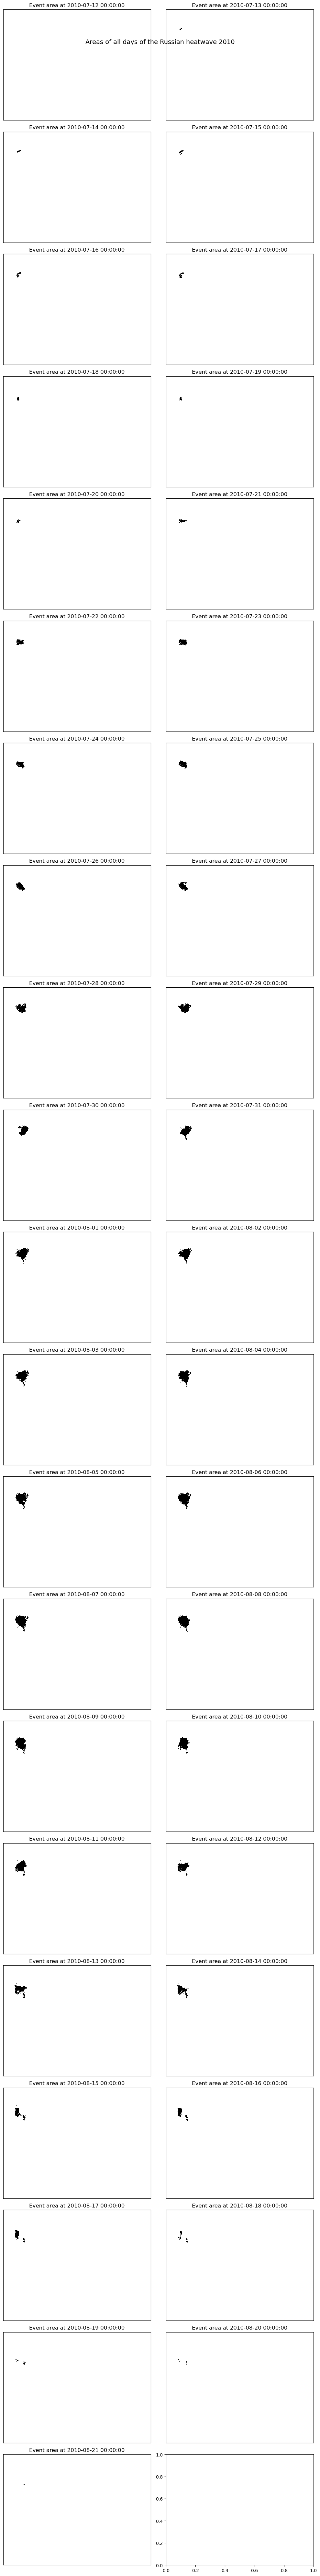

In [11]:
# Create a figure with multiple subplots (adjust layout as needed)
fig, axes = plt.subplots(21, 2, figsize=(10, 80))  # Adjust rows, columns, and figure size

# Define the colormap
colors = [(0, 0, 0), (255, 0, 0)]  
cmap = matplotlib.colors.ListedColormap(colors)

# Loop through dates and plot each time slice on a subplot
for i, date in enumerate(dates_list):
    # Select the desired time slice from the dataset
    time_slice = str(date) 

    # Get the current subplot using integer division and modulo
    row, col = i // 2, i % 2
    ax = axes[row, col]

    # Plot data on the current subplot
    data_slice = ds_blobs.sel(Ti=time_slice)

    # Mask all non-13136 values
    masked_data = ma.masked_where(data_slice['labels'] != 42561, data_slice['labels'])

    # Use masked data values and original coordinates
    ax.pcolormesh(
        data_slice['longitude'], data_slice['latitude'], masked_data,
        shading='auto', cmap=cmap
    )
    ax.set_title(f'Event area at {time_slice}')
    ax.set_xticks([])
    ax.set_yticks([])

# Adjust the main figure layout (optional)
fig.suptitle('Areas of all days of the Russian heatwave 2010', fontsize=14)
plt.tight_layout()  # Adjust spacing between subplots
plt.show()


The above plots show the area of all time slices of the Russian heatwave where both drought and temperature are extreme. The next plot shows the Gross Primary Productivity with the core area mask applied on the first day and on the last day of the event. For this plot, the according mask is loaded and prepared to match the grid and dimensions of the GPP dataset. The core area masks are already precomputed which was done in _01_create_core_area_masks.ipynb_. They will be loaded into memory separately of this notebook when needed.

In [15]:
# Import core area mask
current_directory = os.getcwd() # Get the current script's directory
file_path_42561 = os.path.join(current_directory, '..', 'data/masks/42561.npy') # Construct the path to the data directory
core_area_mask = np.load(file_path_42561)

# Determine original coordinates
lat_orig = ds_blobs['latitude']
lon_orig = ds_blobs['longitude']

# Prepare core area mask (reshaping, regridding)
# Change nan values to 0
core_area_mask = np.where(np.isnan(core_area_mask), 0, core_area_mask)

# Wrap longitudes from 0-360 to -180 to 180 
lon_orig_wrapped = np.where(lon_orig > 180, lon_orig - 360, lon_orig)

# Sort the longitudes and adjust the mask data accordingly
sorted_indices = np.argsort(lon_orig_wrapped)
lon_orig_wrapped_sorted = lon_orig_wrapped[sorted_indices]
core_area_mask_sorted = core_area_mask[:, sorted_indices]

# Create a DataArray with wrapped and sorted coordinates
core_area_mask_da = xr.DataArray(core_area_mask_sorted, 
                                        dims=["latitude", "longitude"],
                                        coords={"latitude": lat_orig, "longitude": lon_orig_wrapped_sorted})

# Rename latitude and longitude to have the same names as gpp dataset
core_area_mask_da = core_area_mask_da.rename({"latitude": "lat", "longitude": "lon"})

# Regrid the core_area_mask to match gpp's coordinates using interpolation
core_area_mask_regridded = core_area_mask_da.interp(lat=gpp.lat, lon=gpp.lon, method="nearest")

# Change mask to boolean
core_area_mask_regridded = core_area_mask_regridded.astype(bool)
            
# Mask dataset to the core area of the blob
gpp_for_plotting = gpp.where(core_area_mask_regridded)

/home/bgrandt/.conda/envs/blobs/lib/python3.12/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/home/bgrandt/.conda/envs/blobs/lib/python3.12/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/home/bgrandt/.conda/envs/blobs/lib/python3.12/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


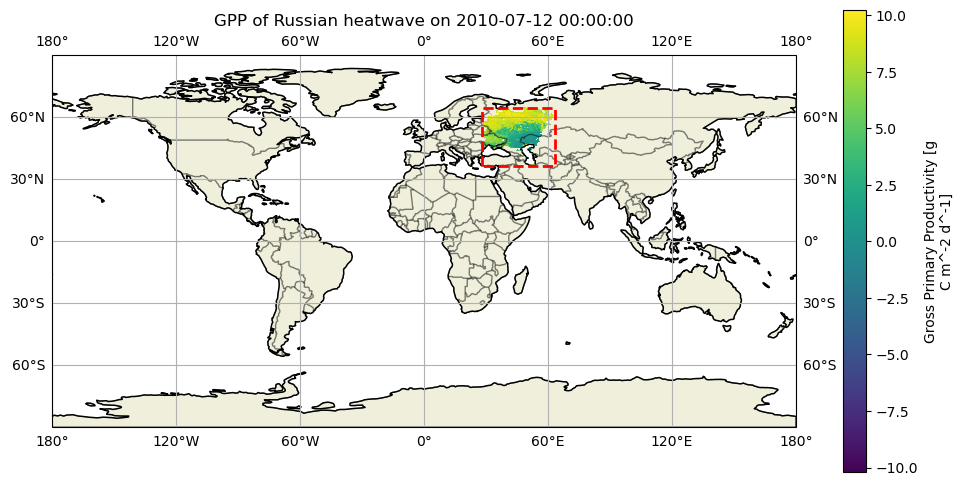

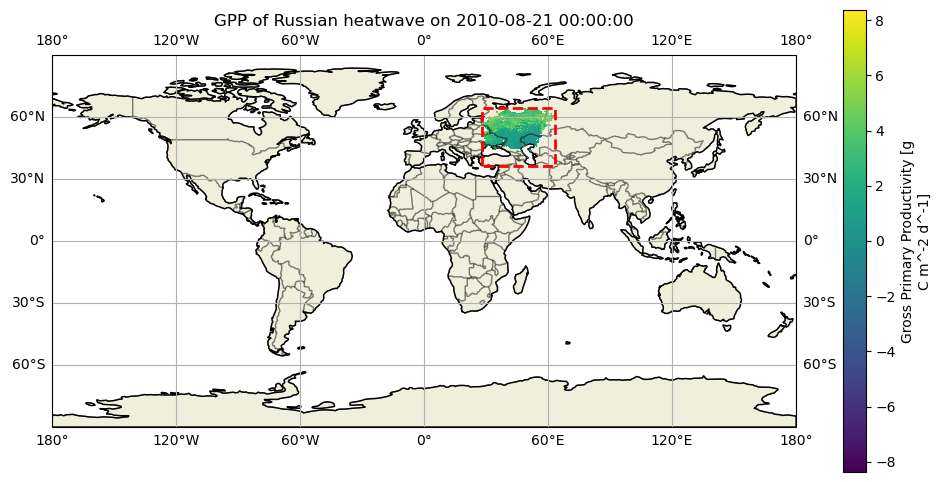

In [18]:
# Define bounding box of event for plot
lat_min_nearest = gpp.sel(lat=df_fluxcom.loc[42561, 'latitude_min'], method='nearest').lat.values
lat_max_nearest = gpp.sel(lat=df_fluxcom.loc[42561, 'latitude_max'], method='nearest').lat.values
lon_min_nearest = gpp.sel(lon=df_fluxcom.loc[42561, 'longitude_min'], method='nearest').lon.values
lon_max_nearest = gpp.sel(lon=df_fluxcom.loc[42561, 'longitude_max'], method='nearest').lon.values

#######################
## Plot GPP before event
event_start = df_fluxcom.loc[42561, 'start_time']

gpp_date_masked = gpp_for_plotting.sel(time=event_start, method='nearest')

# Create the plot
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the data
gpp_date_masked.plot.imshow(ax=ax, cmap="viridis", add_colorbar=True, transform=ccrs.PlateCarree())

# Add country outlines
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)
ax.add_feature(cfeature.COASTLINE, linestyle='-', alpha=0.5)
ax.add_feature(cfeature.LAND, edgecolor='black')

# Set the extent to show the whole world
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# Add gridlines
ax.gridlines(draw_labels=True)

# Define bounding box coordinates
bounding_box_coords = [
    (lon_min_nearest, lat_min_nearest),  # Bottom-left
    (lon_min_nearest, lat_max_nearest),  # Top-left
    (lon_max_nearest, lat_max_nearest),  # Top-right
    (lon_max_nearest, lat_min_nearest),  # Bottom-right
    (lon_min_nearest, lat_min_nearest)   # Closing the loop
]

# Create a polygon from the bounding box coordinates
polygon = Polygon(bounding_box_coords)

# Add bounding box to the plot
x, y = polygon.exterior.xy
ax.plot(x, y, color='red', linestyle='--', linewidth=2, transform=ccrs.PlateCarree())

plt.title(f'GPP of Russian heatwave on {event_start}')
plt.show()

#######################
## Plot GPP after event
event_end = df_fluxcom.loc[42561, 'end_time']

gpp_date = gpp_for_plotting.sel(time=event_end, method='nearest')

# Create the plot
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the data
gpp_date.plot.imshow(ax=ax, cmap="viridis", add_colorbar=True, transform=ccrs.PlateCarree())

# Add country outlines
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)
ax.add_feature(cfeature.COASTLINE, linestyle='-', alpha=0.5)
ax.add_feature(cfeature.LAND, edgecolor='black')

# Set the extent to show the whole world
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# Add gridlines
ax.gridlines(draw_labels=True)

# Define bounding box coordinates
bounding_box_coords = [
    (lon_min_nearest, lat_min_nearest),  # Bottom-left
    (lon_min_nearest, lat_max_nearest),  # Top-left
    (lon_max_nearest, lat_max_nearest),  # Top-right
    (lon_max_nearest, lat_min_nearest),  # Bottom-right
    (lon_min_nearest, lat_min_nearest)   # Closing the loop
]

# Create a polygon from the bounding box coordinates
polygon = Polygon(bounding_box_coords)

# Add bounding box to the plot
x, y = polygon.exterior.xy
ax.plot(x, y, color='red', linestyle='--', linewidth=2, transform=ccrs.PlateCarree())

plt.title(f'GPP of Russian heatwave on {event_end}')
plt.show()

On the first glance, you can observe that the GPP values on the masked data are lower at the end of the event than at the beginning. This is what we are aiming for. In the next step, we will compute our ecosystem parameters for all events.

# 4. Compute ecosystem response parameters

For all events that are left over in the dataframes df_fluxcom and df_gleam, we compute ecosystem response parameters. We will use Gross Primary Productivity (GPP), Terrestrial Ecosystem Respiration (TER) and Evaporative Stress (EvS). For each of these we will compute the average of the 14 days before and of the 14 days after each event over the whole area that was affected by the respective event. From these two means, we compute the difference (delta). These can give us some insights in how vegetation in the respective area responded to the compund drought and heat event.

## 4.1 Compute GPP values for each event over the respective event area

In [17]:
# Determine original coordinates
lat_orig = ds_blobs['latitude']
lon_orig = ds_blobs['longitude']

In [19]:
for event, event_data in df_fluxcom.iterrows():
    # Import core area mask according to the event label
    file_path = os.path.join(current_directory, '..', f'data/masks/{str(event)}.npy')
    core_area_mask = np.load(file_path)

    # Prepare core area mask (reshaping, regridding)
    # Change nan values to 0
    core_area_mask = np.where(np.isnan(core_area_mask), 0, core_area_mask)

    # Wrap longitudes from 0-360 to -180 to 180
    lon_orig_wrapped = np.where(lon_orig > 180, lon_orig - 360, lon_orig)

    # Sort the longitudes and adjust the mask data accordingly
    sorted_indices = np.argsort(lon_orig_wrapped)
    lon_orig_wrapped_sorted = lon_orig_wrapped[sorted_indices]
    core_area_mask_sorted = core_area_mask[:, sorted_indices]

    # Create a DataArray with wrapped and sorted coordinates
    core_area_mask_da = xr.DataArray(core_area_mask_sorted, 
                                                        dims=["latitude", "longitude"],
                                                        coords={"latitude": lat_orig, "longitude": lon_orig_wrapped_sorted})

    # Rename latitude and longitude to have the same names as gpp dataset
    core_area_mask_da = core_area_mask_da.rename({"latitude": "lat", "longitude": "lon"})

    # Regrid the core_area_mask to match gpp's coordinates using interpolation
    core_area_mask_regridded = core_area_mask_da.interp(lat=gpp.lat, lon=gpp.lon, method="nearest")

    # Change mask to boolean
    core_area_mask_regridded = core_area_mask_regridded.astype(bool)

    # Mask dataset to the core area of the blob
    masked_gpp = gpp.where(core_area_mask_regridded)

    # Slice dataset to the 14 days before the blob event
    avg_before = masked_gpp.sel(time=slice(df_fluxcom.loc[event, 'start_time'] - pd.Timedelta(days=14), df_fluxcom.loc[event, 'start_time'])).mean(dim=['time', 'lat', 'lon']).compute()
    df_fluxcom.loc[event, 'GPP_mean_before'] = avg_before.item() # Append average value before event to the dataframe in new column

    # Slice dataset to the 14 days after the blob event
    avg_after = masked_gpp.sel(time=slice(df_fluxcom.loc[event, 'end_time'], df_fluxcom.loc[event, 'end_time'] + pd.Timedelta(days=14))).mean(dim=['time', 'lat', 'lon']).compute()
    df_fluxcom.loc[event, 'GPP_mean_after'] = avg_after.item() # Append average value after event to the dataframe in new column

    # Compute difference
    delta = avg_after.item() - avg_before.item()
    df_fluxcom.loc[event, 'GPP_delta'] = delta # Append result to dataframe

/tmp/ipykernel_1532/2828486245.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fluxcom.loc[event, 'GPP_mean_before'] = avg_before.item() # Append average value before event to the dataframe in new column
/tmp/ipykernel_1532/2828486245.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fluxcom.loc[event, 'GPP_mean_after'] = avg_after.item() # Append average value after event to the dataframe in new column
/tmp/ipykernel_1532/2828486245.py:49: SettingWithCopyWarning: 
A value is trying to be set 

42561
<xarray.DataArray 'gross_primary_productivity' ()> Size: 4B
array(6.146357, dtype=float32)
<xarray.DataArray 'gross_primary_productivity' ()> Size: 4B
array(2.4097033, dtype=float32)
-3.7366538047790527
51252
<xarray.DataArray 'gross_primary_productivity' ()> Size: 4B
array(1.8467429, dtype=float32)
<xarray.DataArray 'gross_primary_productivity' ()> Size: 4B
array(2.5332541, dtype=float32)
0.6865112781524658
55755
<xarray.DataArray 'gross_primary_productivity' ()> Size: 4B
array(2.343996, dtype=float32)
<xarray.DataArray 'gross_primary_productivity' ()> Size: 4B
array(3.1418774, dtype=float32)
0.7978813648223877
44770
<xarray.DataArray 'gross_primary_productivity' ()> Size: 4B
array(1.4006428, dtype=float32)
<xarray.DataArray 'gross_primary_productivity' ()> Size: 4B
array(1.4498849, dtype=float32)
0.04924213886260986


## 4.2 Compute TER values before and after the event

In [ ]:
for event, event_data in df_fluxcom.iterrows():

    # Import core area mask according to event label
    file_path = os.path.join(current_directory, '..', f'data/masks/{str(event)}.npy')
    core_area_mask = np.load(file_path)

    # Prepare core area mask (reshaping, regridding)
    # Change nan values to 0
    core_area_mask = np.where(np.isnan(core_area_mask), 0, core_area_mask)

    # Wrap longitudes from 0-360 to -180 to 180
    lon_orig_wrapped = np.where(lon_orig > 180, lon_orig - 360, lon_orig)

    # Sort the longitudes and adjust the mask data accordingly
    sorted_indices = np.argsort(lon_orig_wrapped)
    lon_orig_wrapped_sorted = lon_orig_wrapped[sorted_indices]
    core_area_mask_sorted = core_area_mask[:, sorted_indices]

    # Create a DataArray with wrapped and sorted coordinates
    core_area_mask_da = xr.DataArray(core_area_mask_sorted, 
                                            dims=["latitude", "longitude"],
                                            coords={"latitude": lat_orig, "longitude": lon_orig_wrapped_sorted})

    # Rename latitude and longitude to have the same names as ter dataset
    core_area_mask_da = core_area_mask_da.rename({"latitude": "lat", "longitude": "lon"})

    # Regrid the core_area_mask to match ter's coordinates using interpolation
    core_area_mask_regridded = core_area_mask_da.interp(lat=ter.lat, lon=ter.lon, method="nearest")

    # Change mask to boolean
    core_area_mask_regridded = core_area_mask_regridded.astype(bool)
                
    # Mask dataset to the core area of the blob
    masked_ter = ter.where(core_area_mask_regridded)
                
    # Slice dataset to the 14 days before the blob event
    avg_before = masked_ter.sel(time=slice(df_fluxcom.loc[event, 'start_time'] - pd.Timedelta(days=14), df_fluxcom.loc[event, 'start_time'])).mean(dim=['time', 'lat', 'lon']).compute()
    df_fluxcom.loc[event, 'TER_mean_before'] = avg_before.item() # Append average value before event to the dataframe in new column
                
    # Slice dataset to the 14 days after the blob event
    avg_after = masked_ter.sel(time=slice(df_fluxcom.loc[event, 'end_time'], df_fluxcom.loc[event, 'end_time'] + pd.Timedelta(days=14))).mean(dim=['time', 'lat', 'lon']).compute()
    df_fluxcom.loc[event, 'TER_mean_after'] = avg_after.item() # Append average value after event to the dataframe in new column
                
    # Compute difference
    delta = avg_after.item() - avg_before.item()
    df_fluxcom.loc[event, 'TER_delta'] = delta # Append result to dataframe

## 4.3 Compute EvS values before and after the event

In [ ]:
for event, event_data in df_gleam.iterrows():

    # Import core area mask according to event label
    file_path = os.path.join(current_directory, '..', f'data/masks/{str(event)}.npy')
    core_area_mask = np.load(file_path)

    # Prepare core area mask (reshaping, regridding)
    # Change nan values to 0
    core_area_mask = np.where(np.isnan(core_area_mask), 0, core_area_mask)

    # Wrap longitudes from 0-360 to -180 to 180
    lon_orig_wrapped = np.where(lon_orig > 180, lon_orig - 360, lon_orig)

    # Sort the longitudes and adjust the mask data accordingly
    sorted_indices = np.argsort(lon_orig_wrapped)
    lon_orig_wrapped_sorted = lon_orig_wrapped[sorted_indices]
    core_area_mask_sorted = core_area_mask[:, sorted_indices]

    # Create a DataArray with wrapped and sorted coordinates
    core_area_mask_da = xr.DataArray(core_area_mask_sorted, 
                                            dims=["latitude", "longitude"],
                                            coords={"latitude": lat_orig, "longitude": lon_orig_wrapped_sorted})

    # Rename latitude and longitude to have the same names as EvS dataset
    core_area_mask_da = core_area_mask_da.rename({"latitude": "lat", "longitude": "lon"})

    # Regrid the core_area_mask to match EvS's coordinates using interpolation
    core_area_mask_regridded = core_area_mask_da.interp(lat=evs.lat, lon=evs.lon, method="nearest")

    # Change mask to boolean
    core_area_mask_regridded = core_area_mask_regridded.astype(bool)
                
    # Mask dataset to the core area of the blob
    masked_evs = evs.where(core_area_mask_regridded)
                
    # Slice dataset to the 14 days before the blob event
    avg_before = masked_evs.sel(time=slice(df_gleam.loc[event, 'start_time'] - pd.Timedelta(days=14), df_gleam.loc[event, 'start_time'])).mean(dim=['time', 'lat', 'lon']).compute()
    df_gleam.loc[event, 'EvS_mean_before'] = avg_before.item() # Append average value before event to the dataframe in new column
                
    # Slice dataset to the 14 days after the blob event
    avg_after = masked_evs.sel(time=slice(df_gleam.loc[event, 'end_time'], df_gleam.loc[event, 'end_time'] + pd.Timedelta(days=14))).mean(dim=['time', 'lat', 'lon']).compute()
    df_gleam.loc[event, 'EvS_mean_after'] = avg_after.item() # Append average value after event to the dataframe in new column
                
    # Compute difference
    delta = avg_after.item() - avg_before.item()
    df_gleam.loc[event, 'EvS_delta'] = delta # Append result to dataframe

## 4.4 Drop rows with NAs in important columns

In [ ]:
# Create subsets of important columns
subset_fluxcom = ['GPP_mean_before', 'GPP_mean_after', 'GPP_delta', 
                  'TER_mean_before', 'TER_mean_after', 'TER_delta']

subset_gleam = ['EvS_mean_before', 'EvS_mean_after', 'EvS_delta']

# Drop NaNs
df_fluxcom = df_fluxcom.dropna(subset=subset_fluxcom)
df_gleam = df_gleam.dropna(subset=subset_gleam)

print(f'Length of fluxcom dataset: {len(df_fluxcom)}')
print(f'Length of gleam dataset: {len(df_gleam)}')

# 5. Write intermediate step results of the delta values to file

We write the intermediate step results to a CSV file in the data directory. Thus, we don't have to recompute the data every time we want to do some analysis on it.

In [ ]:
## CSV with absolute values

# Create relative path
data_directory = os.path.join(current_directory, '..', 'data/') # Construct the path to the data directory

output_file_path_fluxcom = os.path.join(data_directory, 'fluxcom_preprocessed_corearea.csv') # Construct the path to the output file
output_file_path_gleam = os.path.join(data_directory, 'gleam_preprocessed_corearea.csv') # Construct the path to the output file

# Save to .csv
df_fluxcom.to_csv(output_file_path_fluxcom, mode='w')

df_gleam.to_csv(output_file_path_gleam, mode='w')
